In [1]:
from tensorflow.python.platform import build_info as tf_build_info
tf_build_info.build_info
import tensorflow as tf

from platform import python_version
print(python_version())

print(tf.__version__)

2024-04-17 07:03:55.714117: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 07:03:55.714168: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 07:03:55.715329: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-17 07:03:55.993012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-17 07:04:00.660375: W tensorflow/c

3.11.9
2.14.0


In [2]:
from tensorflow.keras import layers, optimizers, losses, metrics, activations, regularizers, callbacks
from keras.models import Model
import numpy as np
import pandas as pd
import shap

In [3]:
# from tensorflow.keras.models import load_model
# model = load_model('ST-CNN-GAP-5.h5')
from tensorflow.keras.models import load_model
model = load_model(r'/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/model/ST-CNN-5_lead3new.h5')

2024-04-17 07:04:29.021305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1666 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:5e:00.0, compute capability: 7.5


In [4]:
# Load and preprocess an example ECG signal for visualization
import wfdb
import numpy as np

def load_raw_data(filename, sampling_rate, path):
    if sampling_rate == 100:
        data, meta = wfdb.rdsamp(path + filename + "_lr")
    else:
        data, meta = wfdb.rdsamp(path + filename + "_hr")
    return data

# Example usage
# filename_to_load = "21775"  # Replace with the specific filename you want to load
# filename_to_load = "02696"  # Hypertrophy
# filename_to_load = "03333"  # Normal ECG
# filename_to_load = "03123"  # CD
# filename_to_load = "03196"  # Normal ECG
filename_to_load = "03482"  # MI
# filename_to_load = "00420"  # Norm 
sampling_rate = 100
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/02000/"
# path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/21000/"
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"

input_example = load_raw_data(filename_to_load, sampling_rate, path)


In [5]:
input_example.shape

(1000, 12)

In [6]:
import numpy as np

# Extracting values from the second column (Lead 3)
input_example = input_example[:, 2]

In [7]:
input_example = input_example.reshape(1, 1, 1000, 1)   # Add another channel

In [8]:
input_example.shape

(1, 1, 1000, 1)

In [9]:
# Shape of input_example: (1, 1, 1000, 1)
# preprocessed_input = load_image(sys.argv[1])
# x = np.transpose(input_example, (1, 0))                 # transpose matrix
# x = np.expand_dims(x, axis=(0, -1))                # Add another channel on left and right

classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']

predictions = model.predict(input_example)


print("Sample belongs to following classes:")
for i in range(5):
    if predictions[0][i] >= 0.5 :
        print(" * " + classes[i])

2024-04-17 07:04:32.952244: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2024-04-17 07:04:33.631129: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-17 07:04:34.364667: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 5s 5s/step
Sample belongs to following classes:
 * Myocardial Infarcation


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


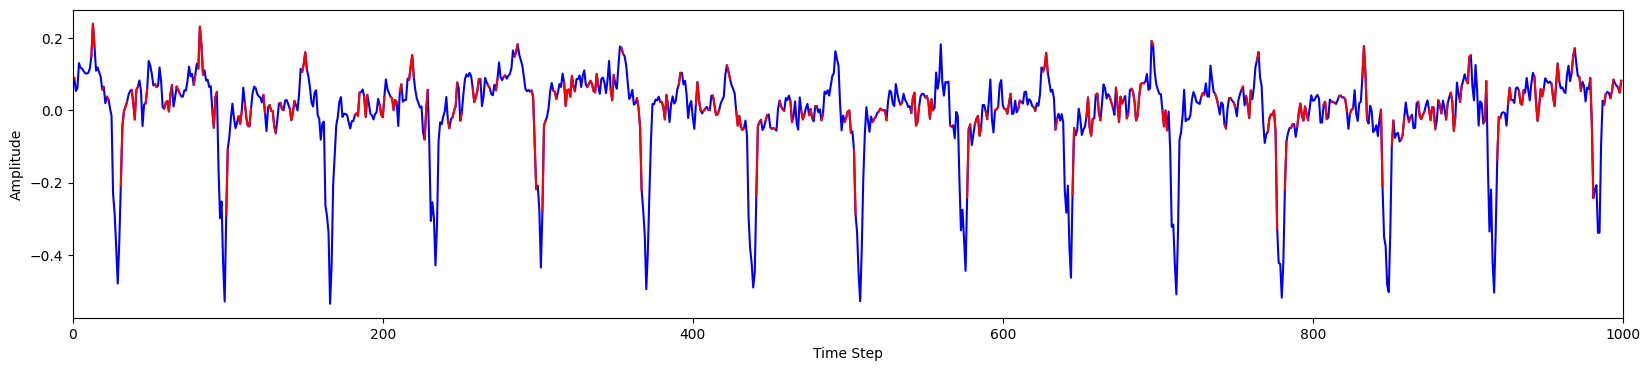

In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the ECG data
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(x, ecg_data[0, 0, :, lead], color='blue')
    
    # Overlay the SHAP values where they are above the threshold
    ax.plot(x, sv_upper, color='red')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Amplitude')
    # ax.set_title(f'SHAP Values Overlay (Sample belongs to: {sample_classes_str})')
    # ax.legend()
        
    # Set the x-axis limits to start from zero
    ax.set_xlim(0, nsteps)
    plt.rc('font', size=20) 
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
threshold=0.0001

plot_shap(ecg_data, sv_data, target_class_idx, lead,threshold, sample_classes=classes)


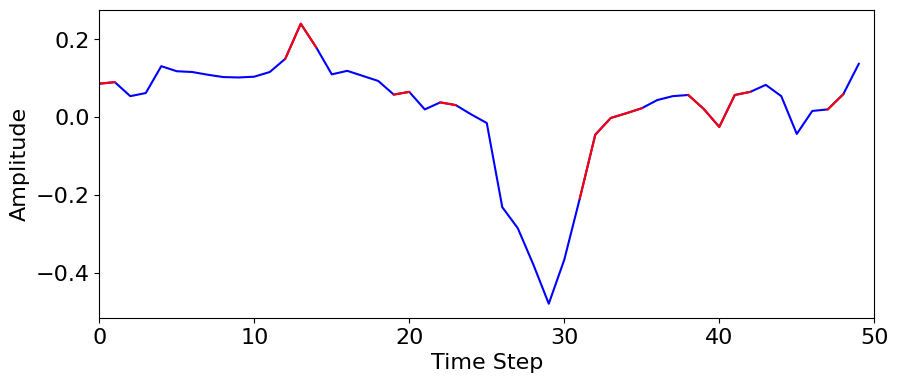

In [14]:
import shap
import numpy as np
import matplotlib.pyplot as plt


# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes, start_index, end_index):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the ECG data
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(x[start_index:end_index], ecg_data[0, 0, start_index:end_index, lead], color='blue')
    
    # Overlay the SHAP values where they are above the threshold
    ax.plot(x[start_index:end_index], sv_upper[start_index:end_index], color='red')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Amplitude')
    # ax.set_title(f'SHAP Values Overlay (Sample belongs to: {sample_classes_str})')
    # ax.legend()
    
    # Set the x-axis limits to start from zero
    ax.set_xlim(start_index, end_index)
    plt.rc('font', size=16)
    
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
# threshold=0.0005
threshold=0.0001

plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes, start_index=0, end_index=50)
# plot_shap2(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes=classes, start_index=550, end_index=600)


In [10]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


segment_length: 2
segment_shap_values: [-1.65773963e-03  1.83711958e-03  4.88493964e-03  1.70316722e-03
  1.02220767e-03  1.76393520e-03 -8.86409264e-03  2.08451692e-03
  8.65503866e-03  1.38053354e-02  9.77931637e-03 -2.78886175e-03
  3.20091983e-03  5.93861789e-02  5.70883714e-02  6.25554798e-03
  1.19233455e-05 -1.29579103e-05  6.91509107e-03 -8.72686971e-04
 -1.12388947e-03  2.95692094e-04  7.10060820e-04  2.93563062e-04
  6.15411811e-03  5.17676631e-03  1.02773448e-03  1.33922312e-03
  9.31399595e-03  2.15838838e-04 -6.75665040e-04 -3.28585429e-06
  1.98635884e-04  9.56419157e-04 -8.31598940e-04  1.11667486e-03
  3.28606518e-04  5.59610373e-04  2.11410155e-03 -2.63327907e-04
  4.30365093e-03 -3.90743138e-03  5.61944721e-03  6.27767574e-03
  1.41365901e-02  3.18055063e-05 -1.24944123e-02  3.21125565e-03
  3.90498601e-02  3.64139001e-03]
top_segments: [ 9 44 48 14 13]


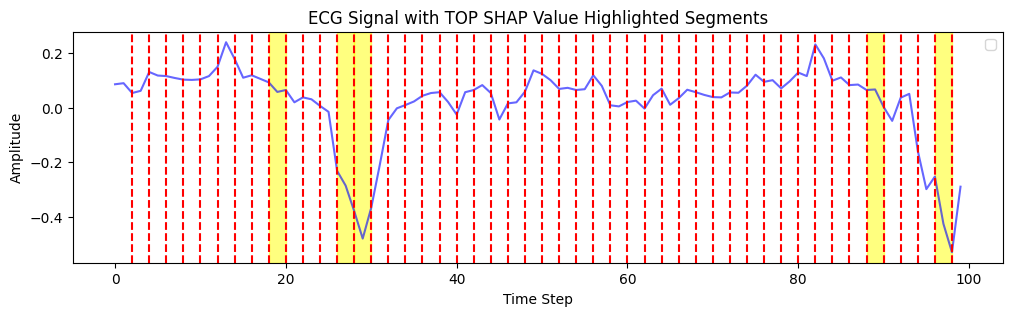

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute SHAP values for each segment
def compute_segment_shap_values(ecg_data, target_class_idx, sv_data, num_slices, lead):
    segment_shap_values = np.zeros(num_slices)
    # num_samples, num_features = sv_data.shape
    segment_length = len(ecg_data) // num_slices
    print(f"segment_length: {segment_length}")


    for i in range(num_slices):
        segment_start = i * segment_length
        segment_end = (i + 1) * segment_length
        # segment_shap_values[i] = np.mean(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
        segment_shap_values[i] = np.max(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
    
    return segment_shap_values


# Define a function to plot the ECG signal with highlighted segments based on top SHAP values
def plot_shap_highlighted_segments(ecg_data, sv_data, num_slices, top_segments):
    ecg_data = ecg_data.squeeze()  # Remove singleton dimensions

    plt.figure(figsize=(12, 3))
    plt.rc('font', size=10)

    # plt.plot(ecg_data, color='blue', label='Original ECG Signal', alpha=0.6)
    plt.plot(ecg_data, color='blue', alpha=0.6)

    # Plot vertical lines to separate segments
    for i in range(1, num_slices):
        plt.axvline(x=i * (len(ecg_data) // num_slices), color='r', linestyle='--')

    # Highlight top influential segments
    for segment in top_segments:
        start_idx = segment * (len(ecg_data) // num_slices)
        end_idx = start_idx + (len(ecg_data) // num_slices)
        plt.axvspan(start_idx, end_idx, color='yellow', alpha=0.5)

    plt.title('ECG Signal with TOP SHAP Value Highlighted Segments')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage:import numpy as np
import matplotlib.pyplot as plt
input_example2 = np.reshape(input_example, (1000, 1))
instance_ecg = input_example2[0:100]
lead = 0
num_slices = 50  # Number of slices
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
segment_shap_values = compute_segment_shap_values(instance_ecg, target_class_idx, shap_values, num_slices, lead)
print(f"segment_shap_values: {segment_shap_values}")
# Get indices of top segments based on SHAP values
top_segments = np.argsort(segment_shap_values)[-5:]  # Change 5 to the number of top segments you want to visualize
print(f"top_segments: {top_segments}")

# Plot the ECG signal with highlighted segments
plot_shap_highlighted_segments(instance_ecg, shap_values, num_slices, top_segments)


segment_length: 1
segment_shap_values: [-2.75889854e-03 -1.50058570e-03  1.96294999e-03 -5.65136550e-04
  4.66691284e-03 -2.22622207e-03  1.37549534e-03 -8.84329551e-04
  7.51039595e-04 -3.59342853e-03  1.75725296e-03  1.97991612e-03
 -8.84538889e-03 -1.71668828e-02 -3.57828150e-03  2.15467624e-03
  6.22431235e-03  8.47461354e-03  1.37628503e-02 -4.00427822e-03
 -1.08333947e-02  9.77477711e-03 -1.49972113e-02 -2.80868914e-03
  7.00721866e-05  3.10450722e-03 -2.30806358e-02  5.85487112e-02
 -1.99662428e-02  5.64037673e-02  5.57499658e-03 -1.11197622e-03
  1.24244340e-04 -7.06877108e-05 -1.35419716e-03 -2.62601352e-05
  4.83206660e-03  6.78579509e-03 -2.65003718e-03 -8.26428819e-04
 -1.05543912e-03 -1.66688371e-03 -5.36217005e-04  2.25347947e-04
 -1.23463001e-03  8.05376796e-04  3.26311390e-04  9.41307298e-05
 -2.57787667e-03  6.17869012e-03]
top_segments: [17 21 18 29 27]


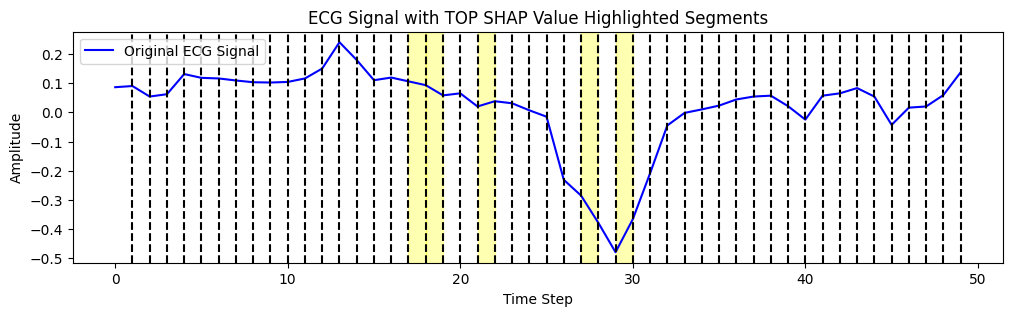

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define a function to compute SHAP values for each segment
def compute_segment_shap_values(ecg_data, target_class_idx, sv_data, num_slices, lead):
    segment_shap_values = np.zeros(num_slices)
    # num_samples, num_features = sv_data.shape
    segment_length = len(ecg_data) // num_slices
    print(f"segment_length: {segment_length}")


    for i in range(num_slices):
        segment_start = i * segment_length
        segment_end = (i + 1) * segment_length
        # segment_shap_values[i] = np.mean(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
        segment_shap_values[i] = np.max(sv_data[target_class_idx][0][:, segment_start:segment_end, 0][lead])
    
    return segment_shap_values


# Define a function to plot the ECG signal with highlighted segments based on top SHAP values
def plot_shap_highlighted_segments(ecg_data, sv_data, num_slices, top_segments):
    ecg_data = ecg_data.squeeze()  # Remove singleton dimensions

    plt.figure(figsize=(12, 3))
    plt.rc('font', size=10)

    plt.plot(ecg_data, color='blue', label='Original ECG Signal')

    # Plot vertical lines to separate segments
    for i in range(1, num_slices):
        plt.axvline(x=i * (len(ecg_data) // num_slices), color='black', linestyle='--')

    # Highlight top influential segments
    for segment in top_segments:
        start_idx = segment * (len(ecg_data) // num_slices)
        end_idx = start_idx + (len(ecg_data) // num_slices)
        plt.axvspan(start_idx, end_idx, color='yellow', alpha=0.3)

    plt.title('ECG Signal with TOP SHAP Value Highlighted Segments')
    plt.xlabel('Time Step')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.show()

# Example usage:import numpy as np
import matplotlib.pyplot as plt
input_example2 = np.reshape(input_example, (1000, 1))
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
instance_ecg = input_example2[0:50]
lead = 0
num_slices = 50  # Number of slices
segment_shap_values = compute_segment_shap_values(instance_ecg, target_class_idx, shap_values, num_slices, lead)
print(f"segment_shap_values: {segment_shap_values}")
# Get indices of top segments based on SHAP values
top_segments = np.argsort(segment_shap_values)[-5:]  # Change 5 to the number of top segments you want to visualize
print(f"top_segments: {top_segments}")

# Plot the ECG signal with highlighted segments
plot_shap_highlighted_segments(instance_ecg, shap_values, num_slices, top_segments)

1/1 [==============================] - 0s 30ms/step


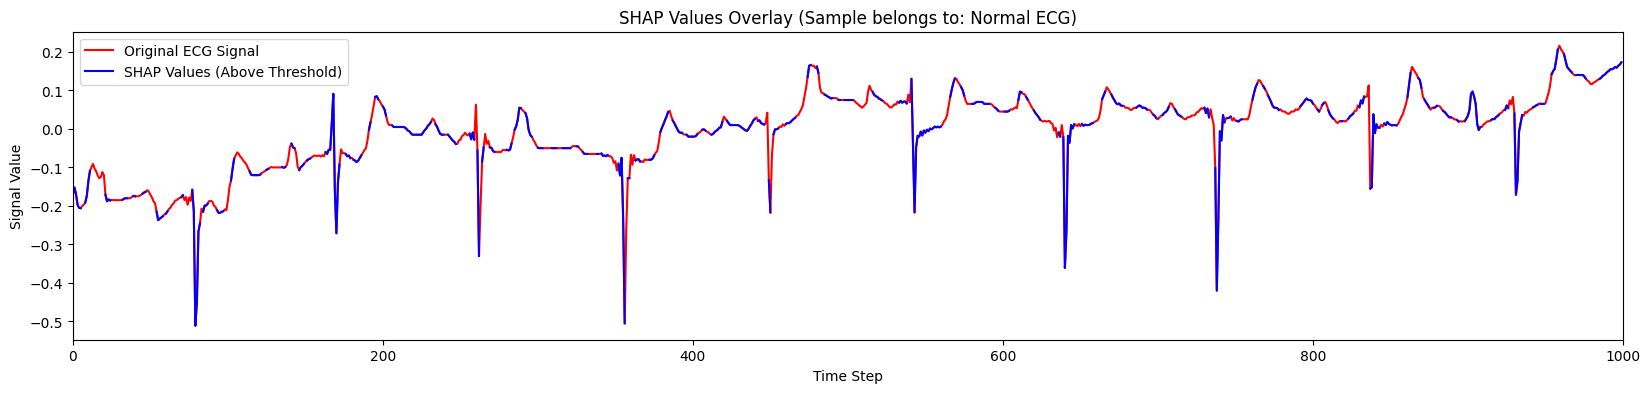

In [18]:

filename_to_load = "03196"  # Normal ECG overleaf
path = "/global/D1/homes/jayao/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2/ptbxl/records100/03000/"
input_example = load_raw_data(filename_to_load, sampling_rate, path)
import numpy as np
# Extracting values from the second column (Lead 3)
input_example = input_example[:, 2]
input_example = input_example.reshape(1, 1, 1000, 1)   # Add another channel
predictions = model.predict(input_example)


import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the ECG data
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(x, ecg_data[0, 0, :, lead], label='Original ECG Signal', color='red')
    
    # Overlay the SHAP values where they are above the threshold
    ax.plot(x, sv_upper, label='SHAP Values (Above Threshold)', color='blue')
    
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.set_title(f'SHAP Values Overlay (Sample belongs to: {sample_classes_str})')
    ax.legend()
    
    # Set the x-axis limits to start from zero
    ax.set_xlim(0, nsteps)
    
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0
threshold=0.001

plot_shap(ecg_data, sv_data, target_class_idx, lead,threshold, sample_classes=classes)


## LIME test


In [ ]:
predictions

array([[0.11364347, 0.12249085, 0.5021059 , 0.2621544 , 0.32670674]],
      dtype=float32)

In [ ]:
import lime
from lime import lime_tabular
import matplotlib.pyplot as plt

import numpy as np
# Create a new variable with the correct shape
input_example_reshaped = input_example.reshape(1, 1000)
print(f"shape of input reshaped {input_example_reshaped.shape}")

# Define prediction function using the provided predictions and converting them to probabilities
def predict_fn(x):
    # Assuming predictions is a numpy array
    # Convert predictions to probabilities by applying softmax function
    # return np.exp(predictions) / np.sum(np.exp(predictions), axis=1, keepdims=True)
    print(f"shape of x {x.shape}")
    print(f"value of of x 0 {x.shape[0]}")
    predictions = np.ones((x.shape[0], 5))  # Example predictions with 5 classes
    print(f"predictions {predictions}")

    return predictions
    

# Initialize LIME Explainer
explainer = lime_tabular.LimeTabularExplainer(input_example_reshaped, feature_names=range(1000), class_names=classes, mode='classification')

# Generate explanation
explanation = explainer.explain_instance(input_example_reshaped[0], predict_fn, num_features=10)

# Visualize explanation
explanation.show_in_notebook()

shape of input reshaped (1, 1000)
shape of x (5000, 1000)
value of of x 0 5000
predictions [[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 ...
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]



                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    


## SHAP test


In [13]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


In [13]:

# shap_values is a list where each element corresponds to Shapley values for a class
# In your case, it should be a list of length 5 (assuming 5 classes)
print("Number of classes:", len(shap_values))
# print("Shape pf shapley:", shap_values.shape)

# Print the shape of Shapley values for each class
for i, class_values in enumerate(shap_values):
    print(f"Class {i + 1} - Shape of Shapley values:", class_values.shape)

Number of classes: 5
Class 1 - Shape of Shapley values: (1, 1, 1000, 1)
Class 2 - Shape of Shapley values: (1, 1, 1000, 1)
Class 3 - Shape of Shapley values: (1, 1, 1000, 1)
Class 4 - Shape of Shapley values: (1, 1, 1000, 1)
Class 5 - Shape of Shapley values: (1, 1, 1000, 1)


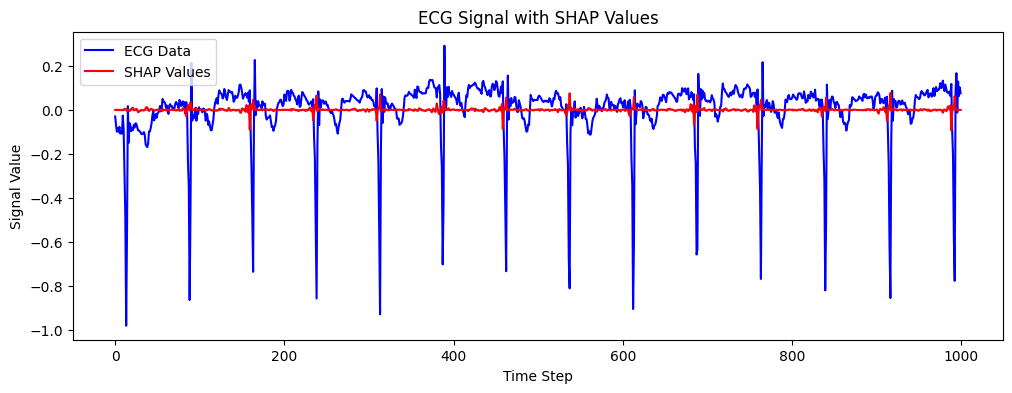

In [65]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, label):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    threshold = 0.2
    
    # Select the SHAP values for the target class
    target_shap_values = sv_data[target_class_idx][0][:, :, 0]
    # print(f"target_shap_values {target_shap_values}")
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, ecg_data[0, 0, :, 0], label='ECG Data', color='blue')
    ax.plot(x, target_shap_values[0], label='SHAP Values', color='red')
    ax.fill_between(x, target_shap_values[0], where=target_shap_values[0] >= threshold, color='red', alpha=0.3)
    ax.fill_between(x, target_shap_values[0], where=target_shap_values[0] < threshold, color='blue', alpha=0.3)
    ax.set_title(label)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.legend()
    plt.show()
    plt.close(fig)

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
sv_data = shap_values

classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarcation', 'Normal ECG', 'ST/T change']
# Select the target class index (e.g., class index 2)
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction

# Plot the SHAP values for the target class
plot_shap(ecg_data, sv_data, target_class_idx, label='ECG Signal with SHAP Values')


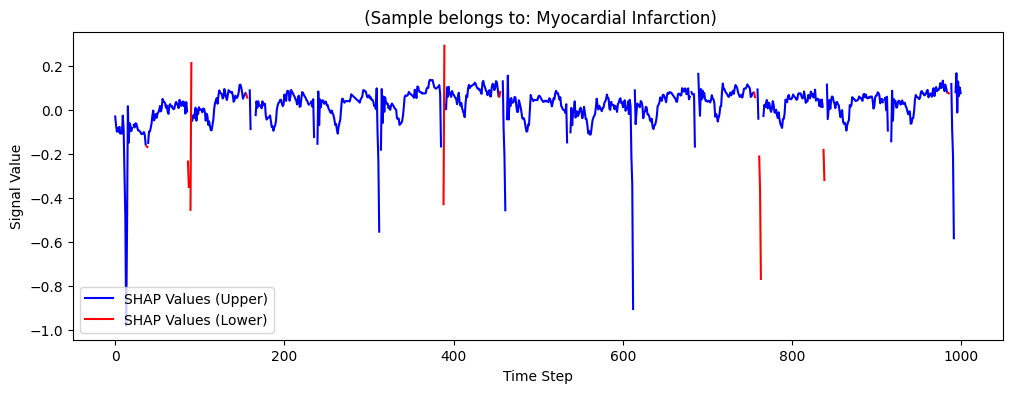

In [88]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume model is your trained model
# input_example is your input example with shape (1, 1, 1000, 1)

# Define a background dataset (baseline) for Integrated Gradients
background = np.zeros((1, 1, 1000, 1))  # You may want to choose a meaningful baseline

# Create an explainer object using the gradient method
explainer = shap.GradientExplainer(model, background)

# Compute Shapley values for the input example
shap_values = explainer.shap_values(input_example)

import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, lead, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    threshold=0.01
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0] [lead]
    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Apply masks to ECG data
    sv_upper = np.ma.masked_where(sv_upper_mask, ecg_data[0, 0, :, lead])
    sv_lower = np.ma.masked_where(sv_lower_mask, ecg_data[0, 0, :, lead])
    
    # Plot the SHAP values
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(x, sv_upper, label='SHAP Values (Upper)', color='blue')
    ax.plot(x, sv_lower, label='SHAP Values (Lower)', color='red')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.set_title(f' (Sample belongs to: {sample_classes_str})')
    ax.legend()
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0

plot_shap(ecg_data, sv_data, target_class_idx, lead, sample_classes=classes)


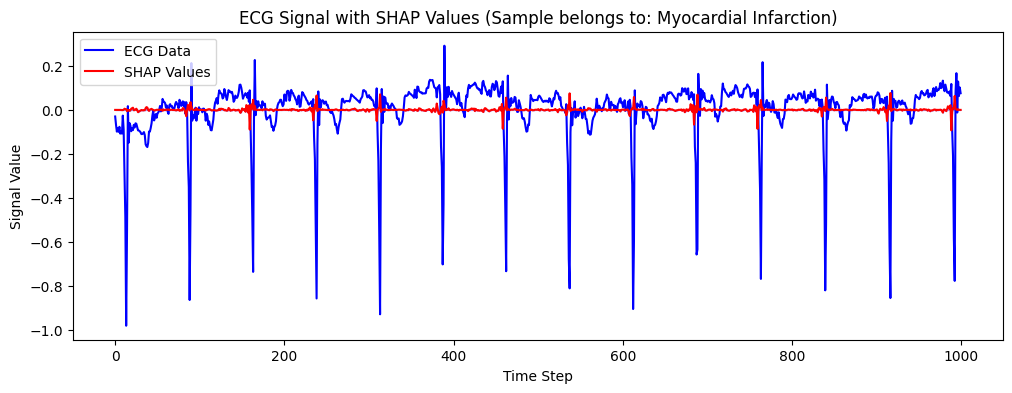

In [84]:
import numpy as np
import matplotlib.pyplot as plt

def plot_shap(ecg_data, sv_data, target_class_idx, label, sample_classes):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    threshold = 0.2
    
    # Select the SHAP values for the target class
    target_shap_values = sv_data[target_class_idx][0][:, :, 0]
    
    # Get the sample classes
    sample_classes_str = ', '.join([classes[i] for i, prob in enumerate(predictions[0]) if prob >= 0.5])
    
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(x, ecg_data[0, 0, :, 0], label='ECG Data', color='blue')
    ax.plot(x, target_shap_values[0], label='SHAP Values', color='red')
    ax.fill_between(x, target_shap_values[0], where=target_shap_values[0] >= threshold, color='red', alpha=0.3)
    ax.fill_between(x, target_shap_values[0], where=target_shap_values[0] < threshold, color='blue', alpha=0.3)
    ax.set_title(label + f' (Sample belongs to: {sample_classes_str})')
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.legend()
    plt.show()
    plt.close(fig)

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
sv_data = shap_values

classes = ['Conduction Disturbance', 'Hypertrophy', 'Myocardial Infarction', 'Normal ECG', 'ST/T change']

# Select the target class index (e.g., class index 2)
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction

# Plot the SHAP values for the target class
plot_shap(ecg_data, sv_data, target_class_idx, label='ECG Signal with SHAP Values', sample_classes=classes)


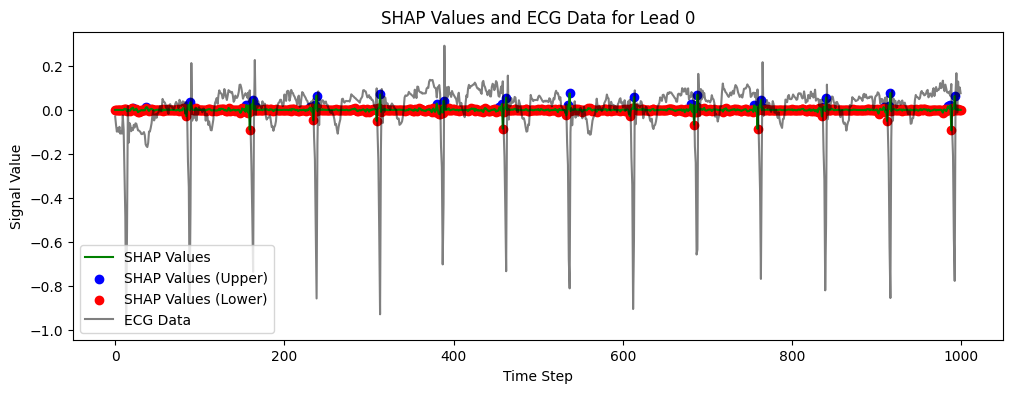

In [83]:
def plot_shap(ecg_data, sv_data, target_class_idx, lead, threshold=0.01):
    nsteps = ecg_data.shape[2]
    x = np.arange(nsteps)
    
    # Extract SHAP values for the specified lead
    lead_shap_values = sv_data[target_class_idx][0][:, :, 0][lead]

    # Create masks based on the threshold
    sv_upper_mask = lead_shap_values >= threshold
    sv_lower_mask = lead_shap_values < threshold
    
    # Plot the SHAP values
    fig, ax = plt.subplots(figsize=(12,4))
    ax.plot(x, lead_shap_values, label='SHAP Values', color='green')
    ax.scatter(x[sv_upper_mask], lead_shap_values[sv_upper_mask], color='blue', label='SHAP Values (Upper)')
    ax.scatter(x[sv_lower_mask], lead_shap_values[sv_lower_mask], color='red', label='SHAP Values (Lower)')
    ax.plot(x, ecg_data[0, 0, :, lead], label='ECG Data', color='black', alpha=0.5)
    ax.set_xlabel('Time Step')
    ax.set_ylabel('Signal Value')
    ax.set_title('SHAP Values and ECG Data for Lead ' + str(lead))
    ax.legend()
    plt.show()

# Example usage:
ecg_data = input_example
sv_data = shap_values
target_class_idx = np.argmax(predictions[0])  # Assuming there's only one prediction
lead = 0  # Assuming we want to plot SHAP values for lead 0

plot_shap(ecg_data, sv_data, target_class_idx, lead)


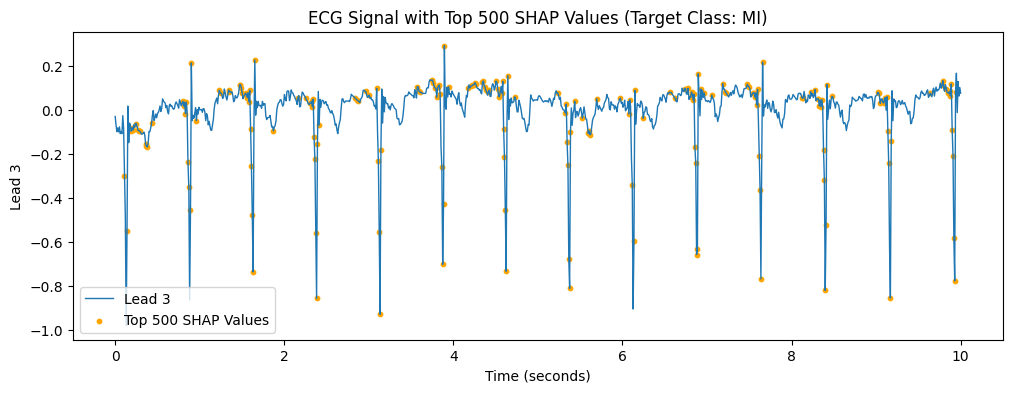

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-200:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 3')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 3')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: MI)')
plt.show()


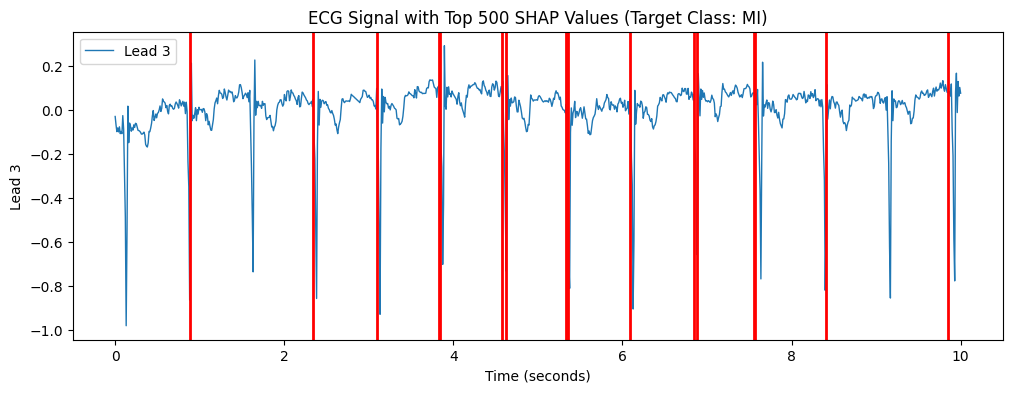

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-50:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)

# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 3')

# Segment ECG based on top SHAP values
segment_start = None
for idx in range(len(top_indices[1])):
    if target_shap_values[top_indices[0][idx], top_indices[1][idx]] > 0:  # Check if SHAP value is positive
        if segment_start is None:
            segment_start = top_indices[1][idx]
    else:
        if segment_start is not None:
            segment_end = top_indices[1][idx]
            ax.axvline(time[segment_start], color='red', linestyle='-', linewidth=2)
            ax.axvline(time[segment_end], color='red', linestyle='-', linewidth=2)
            segment_start = None

ax.set_ylabel('Lead 3')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: MI)')
plt.show()


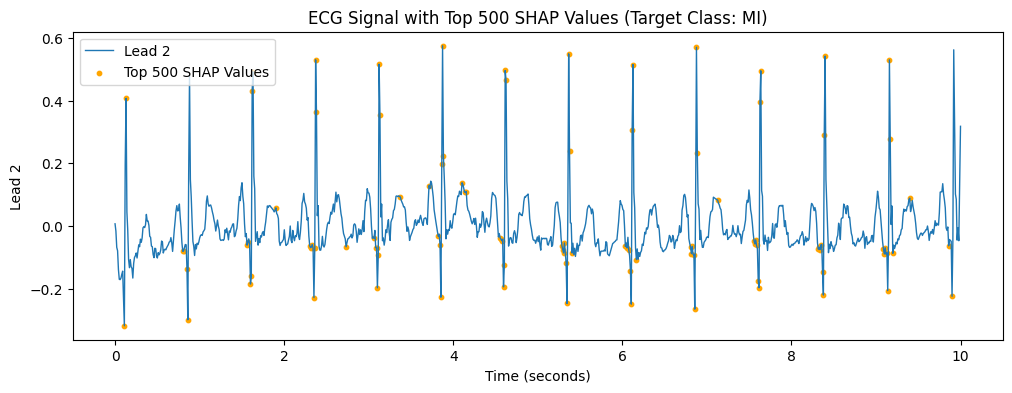

In [101]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-500:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 2')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 2')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: MI)')
plt.show()


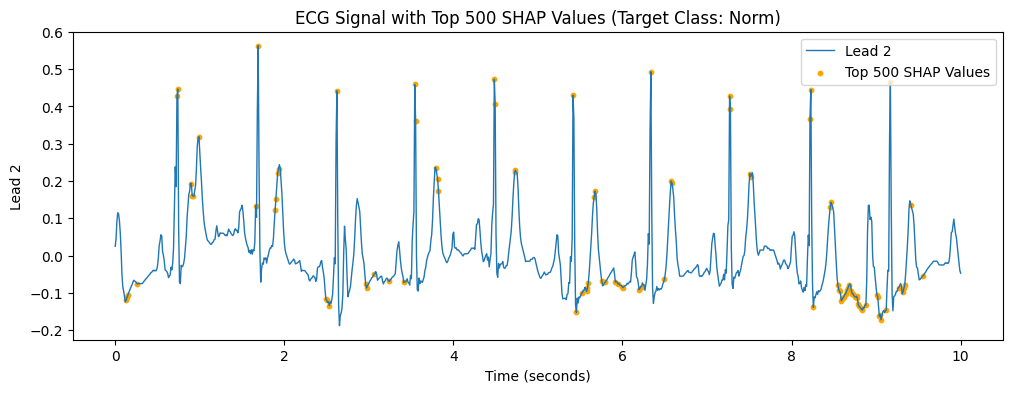

In [130]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 1, 1000, 1]
ecg_data = input_example

# Sample SHAP values with dimensions [batch size, 5, 1, 1000, 1]
shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 2  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[target_class_idx][0][:, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.argsort(np.abs(target_shap_values).ravel())[-100:]
top_indices = np.unravel_index(top_indices, target_shap_values.shape)


# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, ecg_data.shape[2] / sampling_rate, ecg_data.shape[2])

# Plot the ECG signal with overlay of SHAP values for the target class
fig, ax = plt.subplots(figsize=(12, 4))

lead_data = ecg_data[0, 0, :, 0]
ax.plot(time, lead_data, lw=1, label='Lead 2')
top_shap_values = target_shap_values[top_indices]

# Scale the SHAP values to the range of ECG data for better visualization
scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)

# Highlight corresponding ECG signal points with orange color
ax.scatter(time[top_indices[1]], lead_data[top_indices[1]], color='orange', s=10, label='Top 500 SHAP Values')

ax.set_ylabel('Lead 2')
ax.set_xlabel('Time (seconds)')
ax.legend()
plt.title('ECG Signal with Top 500 SHAP Values (Target Class: Norm)')
plt.show()


In [44]:
shap_path = "/global/D1/homes/jayao/XAI-Based-ECG-Diagnostics-main/data/"
# Save SHAP values to a file
np.save(shap_path + 'shap_values.npy', shap_values)

In [17]:
shap_values = np.load('shap_values.npy')
shap_values.shape

# Old output: (5, 5, 12, 1000, 1)

FileNotFoundError: [Errno 2] No such file or directory: 'shap_values.npy'

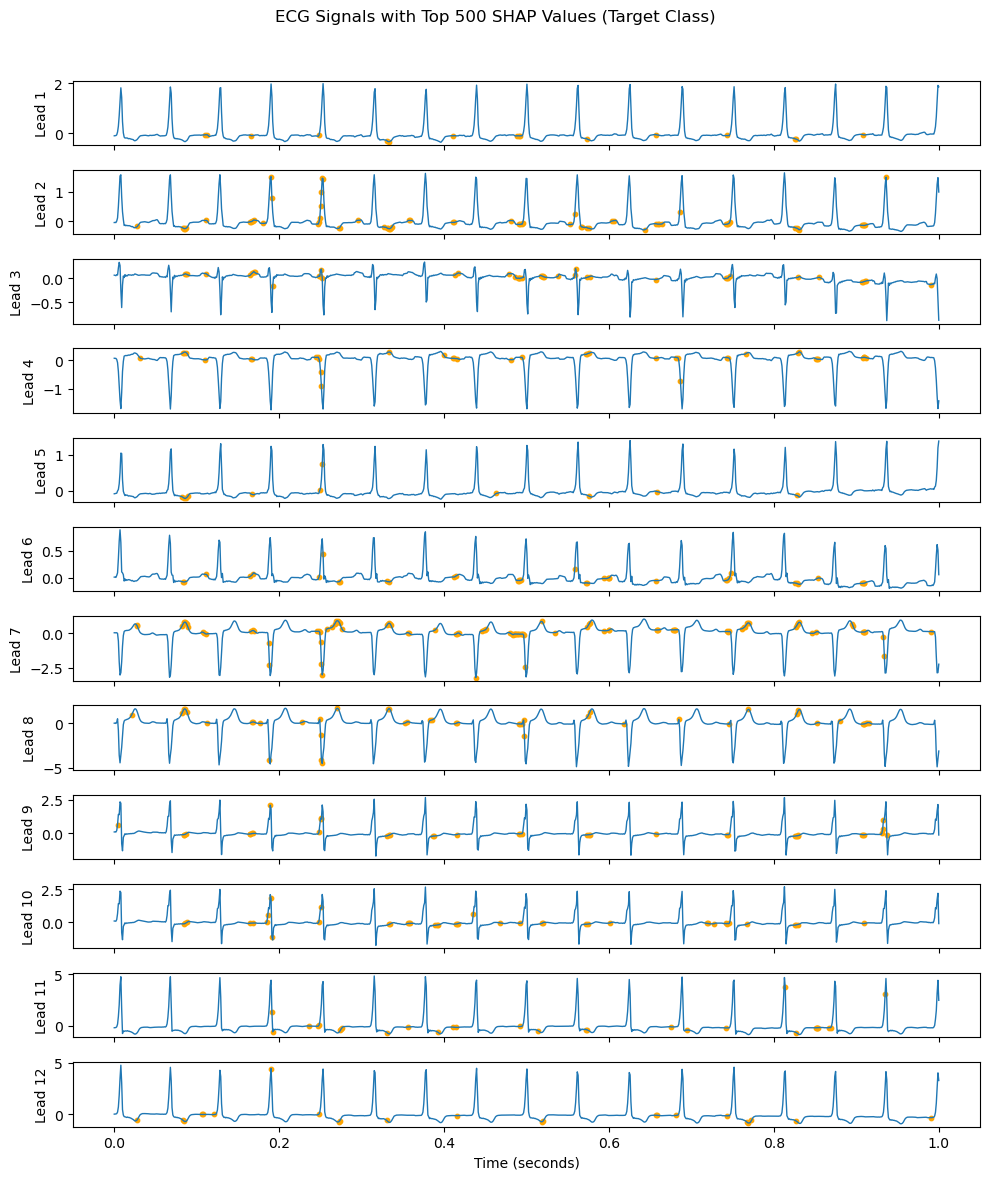

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sample ECG data with dimensions [batch size, 12, 1000, 1]

ecg_data = x
batch_size, num_leads, signal_length, _ = ecg_data.shape

# Sample SHAP values with dimensions [batch size, 5, 12, 1000, 1]

shap_values = shap_values

# Select the SHAP values for the target class (e.g., class 3)
target_class_idx = 1  # Assuming class index 2 corresponds to the target class
target_shap_values = shap_values[0, target_class_idx, :, :, 0]

# Identify the top 500 SHAP values and their corresponding indices
top_indices = np.unravel_index(np.argsort(np.abs(target_shap_values).ravel())[-500:], target_shap_values.shape)

# Create a time array
sampling_rate = 100  # Replace with your actual sampling rate
time = np.linspace(0, signal_length / sampling_rate, signal_length)

# Create subplots for each lead
fig, axes = plt.subplots(num_leads, 1, figsize=(10, 12), sharex=True)

# Plot each lead with overlay of SHAP values for the target class
for lead_idx in range(num_leads):
    lead_data = ecg_data[0, lead_idx, :, 0]
    axes[lead_idx].plot(time, lead_data, lw=1, label=f'Lead {lead_idx + 1}')
    top_shap_indices = np.where(top_indices[0] == lead_idx)[0]
    top_shap_values = target_shap_values[lead_idx, top_indices[1][top_shap_indices]]

    # Scale the SHAP values to the range of ECG data for better visualization
    scaled_shap_values = top_shap_values * (np.max(lead_data) - np.min(lead_data)) + np.min(lead_data)
    
    # Highlight corresponding ECG signal points with orange color
    axes[lead_idx].scatter(time[top_indices[1][top_shap_indices]], lead_data[top_indices[1][top_shap_indices]], color='orange', s=10)
    axes[lead_idx].set_ylabel(f'Lead {lead_idx + 1}')

axes[num_leads - 1].set_xlabel('Time (seconds)')
plt.suptitle('ECG Signals with Top 500 SHAP Values (Target Class)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

